# Visitors time-series analysis and forecast

## Libraries

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from mpl_toolkits import mplot3d

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

## Time series dataset

In [24]:
# downloading timeseries
ts = pd.read_csv("Data\VisitorsToGeorgia_2011-2019.csv", index_col="Date", parse_dates=True)
ts.T.head()

Date,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,...,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31
Visitors,175944,141230,184193,177894,199465,200852,272101,353191,287727,255330,...,507064,549761,618709,727634,882331,1086596,784280,665055,543176,534732


In [25]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2011-01-31 to 2019-12-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Visitors  108 non-null    int64
dtypes: int64(1)
memory usage: 1.7 KB


- The dataset has 108 entries, representing 108 months through Jan 2011 to Dec 2019. 
- There are no missing values. 

## Time series visual inspection

- An upward trend with Compound Annual Growth Rate for 2012-2019 = 13.98%
- Changes in the trend direction in 2014 and 2017. Possible longterm cycle, but more data will be needed.
- Clear seasonality pattern backed by a boxplot graph with visible differences in value distributions through the year.
- From Feb to Aug stable growth, from Sep to Feb steady decrease.
- The values are positive skewed, to the right.

In [26]:
# define CAGR function
def CAGR(ts_column):
    """
    Compound annual growth rate (CAGR). Growth rate that would be required for growth 
    from its Beginning Balance to its Ending Balance.

    Parameters 
    -----------
    ts_column = DataFrame column with Time Series data.

    Returns
    -----------
    Compund growth rate.
    """
    try:
        cagr = (ts_column[-1]/ts_column[0])**(1/(len(ts_column)-1))-1
        cagr = (cagr*100).round(2)
        return cagr
    except:
        print("Pass a Series or a DataFrame column.")

### Monthly and annual view

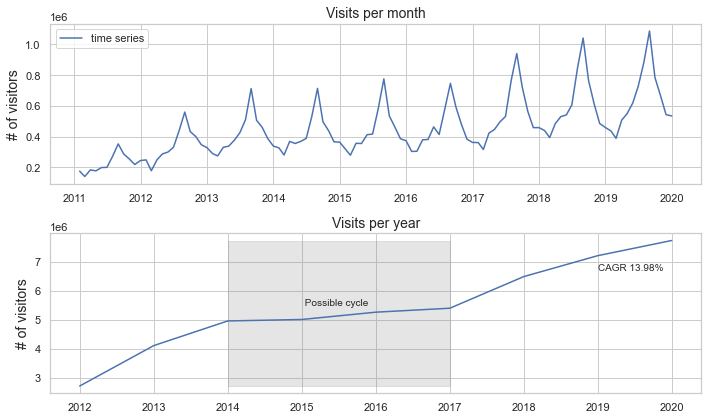

In [27]:
# Getting annaual data
ts_yr = ts["Visitors"].resample("A").sum()

# Plotting  original time series and annual view
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

ax[0].plot(ts["Visitors"])
ax[0].set_title("Visits per month", size="14")
ax[0].set_ylabel('# of visitors', size="14")
ax[0].legend(["time series", "ma12"])

ax[1].fill_betweenx(ts_yr, ts_yr["2013"].index,
                    ts_yr["2016"].index, color="gray", alpha=0.2)
ax[1].plot(ts_yr)
ax[1].annotate("CAGR {}%".format(CAGR(ts_yr)), xy=(
    ts_yr["2018"].index, 6700000), size=10)
ax[1].annotate(" Possible cycle", xy=(ts_yr["2014"].index, 5500000), size=10)
ax[1].set_title("Visits per year", size="14")
ax[1].set_ylabel('# of visitors', size="14")

fig.tight_layout()
plt.show()

### Descriptive statistics

In [28]:
ts.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Visitors,108.0,452195.55,184984.42,141230.0,331275.25,415635.5,534817.25,1086596.0


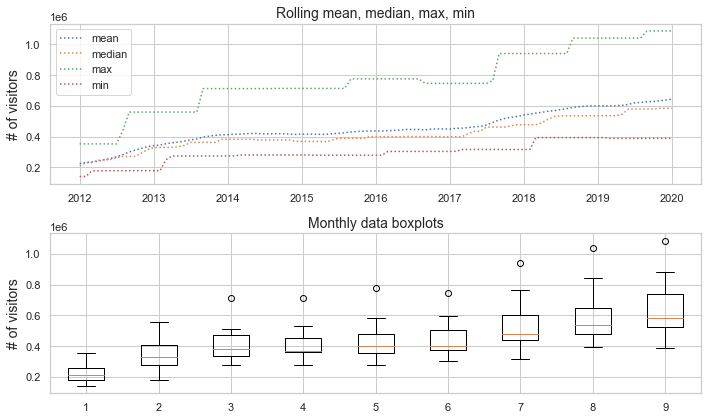

In [29]:
# Plotting basic descriptive statistics
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

ax[0].plot(ts["Visitors"].rolling(12).agg(
    ["mean", "median", "max", "min"]), linestyle="dotted")
ax[0].set_title("Rolling mean, median, max, min", size="14")
ax[0].set_ylabel('# of visitors', size="14")
ax[0].legend(["mean", "median", "max", "min"])

ts['Month'] = ts.index.month
ts['Year'] = ts.index.year
ts_piv = ts.pivot(index="Month", columns="Year", values="Visitors")

month_labels = ["Jan", "Feb", "Mar", "Apr", "May",
                "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

ax[1].boxplot(ts_piv)
ax[1].set_title("Monthly data boxplots", size="14")
ax[1].set_ylabel('# of visitors', size="14")

fig.tight_layout()
plt.show()

## Time series decomposition

### Theoretical background

I decided to decompose time series straight forward, manually, instead of using tools such as Statsmodes seasonal_decompose() function. It helps to understand the logic behind decomposing and provides grater understanding of the analysis.

The underlying logic behind decomposition is the assumption that time series is the combination of trend, seasonal factor, and randomness. In this case, the relation between elements is **multiplicative**, which can be seen on the first plot as you move along the time axis; the higher the growth, the higher the variance in seasonality. 

$$ Ts = t * s * e $$


Following this logic the particular components of the time series are results of transformation of the above equation. 

a) $$ s = \frac {Ts}{t} $$ b) $$ e = \frac{Ts}{t * s} $$

Where:

- Ts = timeseries
- t = trend
- s = seasonality
- e = random error

### Decomposition and visuals

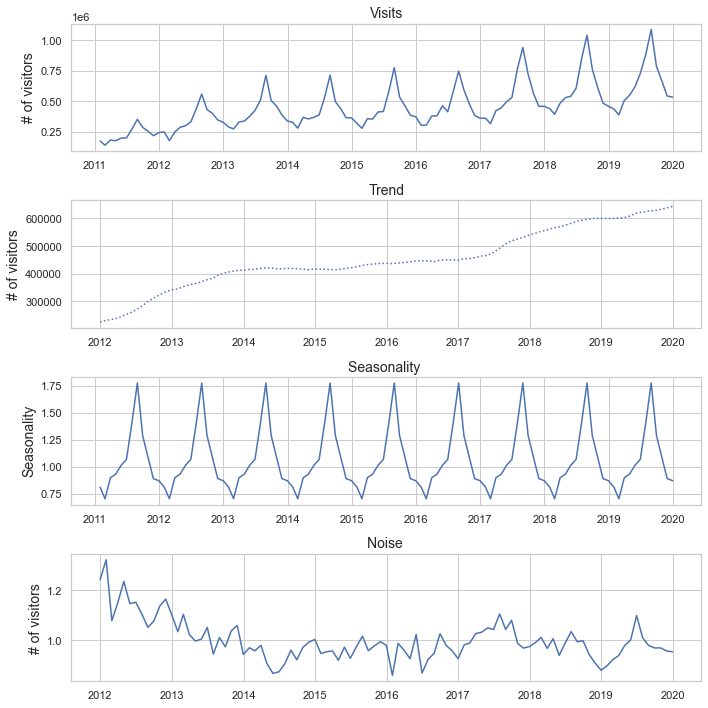

In [30]:
# Identyfing trend using moving average
ts["MA12"] = ts["Visitors"].rolling(window=12).mean()

# Detrending time series
ts["Seasonality+Noise"] = ts["Visitors"] / ts["MA12"]

# Getting seasonality index
seasonality = list(ts.groupby("Month")["Seasonality+Noise"].mean())
ts["Seasonality"] = seasonality * int((ts.shape[0]/12))

# Identifying residuals
ts["Noise"] = ts["Visitors"]/(ts["MA12"]*ts["Seasonality"])
#ts["Noise"] = (ts["Visitors"]/(ts["Trend"]*ts["Seasonality"])-1)*ts["Trend"]

# Plotting results
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 10), sharex=False)

ax[0].plot(ts["Visitors"])
ax[0].set_title("Visits", size="14")
ax[0].set_ylabel('# of visitors', size="14")

ax[1].plot(ts["MA12"], linestyle="dotted")
ax[1].set_title("Trend", size="14")
ax[1].set_ylabel('# of visitors', size="14")

ax[2].plot(ts["Seasonality"])
ax[2].set_title("Seasonality ", size="14")
ax[2].set_ylabel("Seasonality", size="14")

ax[3].plot(ts["Noise"])
ax[3].set_title("Noise ", size="14")
ax[3].set_ylabel('# of visitors', size="14")

fig.tight_layout()
plt.show()

## Seasonality inspection

A deeper dive into seasonality confirms a steady pattern existence. The nine years sample visual inspection shows that in every single year, the pattern had almost identical shape. 

Valuable insights concern the distributions of the values from the per month breakdown shown on a boxplot. The data skews to the right, toward higher positive values. The first half of the year might be less predictable and could be prone to outliers. 

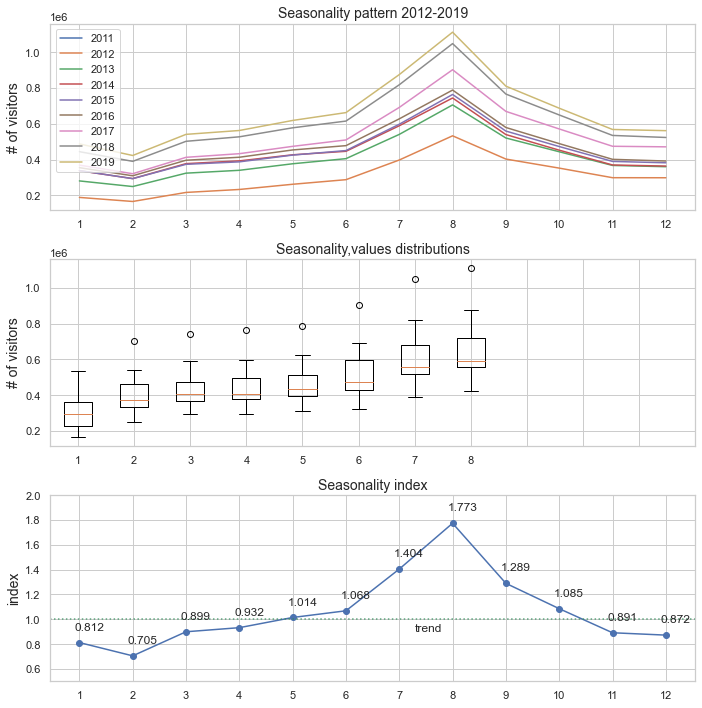

In [31]:
# deeper dive into seasonality
ts["Seasonality_Visitors"] = (ts["Seasonality"] * ts["MA12"])
ts_piv = ts.pivot(index='Month', columns="Year", values="Seasonality_Visitors")

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=False)

ax[0].plot(ts_piv)
ax[0].set_title("Seasonality pattern 2012-2019", size="14")
ax[0].set_ylabel('# of visitors', size="14")
ax[0].set_xticks(ts_piv.index)
ax[0].legend(ts_piv.columns, loc='upper left')

ax[1].boxplot(ts_piv.iloc[:, 1:])
ax[1].set_title("Seasonality,values distributions", size="14")
ax[1].set_ylabel('# of visitors', size="14")
ax[1].set_xticks(ts_piv.index)

sindex = pd.Series(data=ts.groupby("Month")[
                   "Seasonality"].mean(), name="Seasonality_Index").round(3)

ax[2].plot(sindex, marker="o")
ax[2].axhline(1.0, linestyle="dotted", color="seagreen", alpha=0.75)
ax[2].annotate(s="trend", xy=(7.3, 0.9))
ax[2].set_title("Seasonality index", size="14")
ax[2].set_ylabel('index', size="14")
ax[2].set_ylim(bottom=0.5, top=2.0)
ax[2].set_xticks(sindex.index)

for x, y in zip(sindex.index, sindex):
    ax[2].annotate(s=sindex.iloc[x-1], xy=(x-0.1, y+0.1))

plt.tight_layout()
plt.show()

### Seasonality numbers for budgeting

From a business application perspective, instead of seasonality index, more useful for budgeting and forecasting is a monthly contribution to the annual result breakdown. 

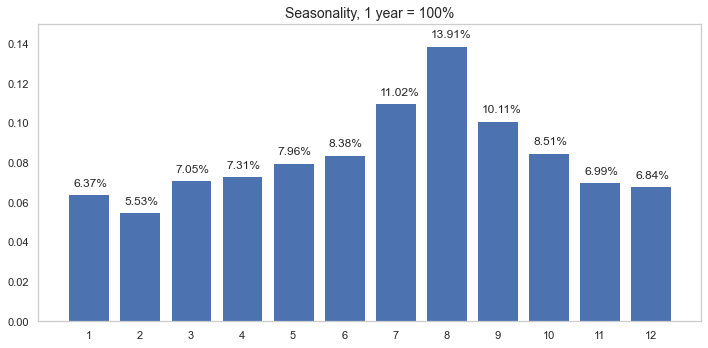

In [32]:
# plotting seasonality in a more usefull terms
x = [i for i in range(1, 13)]
y = [(i/sindex.sum()).round(3) for i in sindex]
s = [str(((i/sindex.sum())*100).round(2))+"%" for i in sindex]

plt.figure(figsize=(10, 5))
plt.bar(x, y)
plt.ylim(top=0.15)
plt.title("Seasonality, 1 year = 100%", size=14)

for s, x, y in zip(s, x, y):
    plt.annotate(s, xy=(x, y), xytext=(x-0.3, y+0.004), size=12)

plt.xticks(sindex.index)

plt.grid(b=None)
plt.tight_layout()
plt.show()

## Linear trend 

A linear trend combined with the seasonality, is useful in forecasting. It might also helps recognizing cyclicality. Having univariate data, a simple linear regression formula applies. 

$$ Y_i = \beta_0 + \beta_1*x_i + e_i $$

Where:
- $Y_i$ = dependent variable
- $\beta_0$ = Y **intercept**
- $\beta_1$ = **slope** coefficient
- $x_i$ = independent variable
- $e_i$ = random error

### Linear Regression model

In [33]:
# preparing data for linear regression
y = ts["MA12"].reset_index(drop=True)[12:].values.reshape(-1, 1)
X = ts["MA12"].reset_index(drop=True)[12:].index.values.reshape(-1, 1)
print("y shape :", y.shape)
print("X shape :", X.shape)

y shape : (96, 1)
X shape : (96, 1)


In [34]:
lr = LinearRegression()
model = lr.fit(X, y)
slope = lr.coef_[0, 0]
intercept = lr.intercept_[0]

# linear regression results
y_pred = [x * slope + intercept for x in range(len(ts))]
ts["LR"] = y_pred

print("Slope: ", slope)
print("Intercept: ", intercept)

Slope:  3565.5284929462828
Intercept:  242971.13279469617


The linear trend formula that applies for the time series dataset is as follows:

$$ Y_i = 3565.53 + 242971.13 * x_i $$

Later we will use it for prediction purposes.

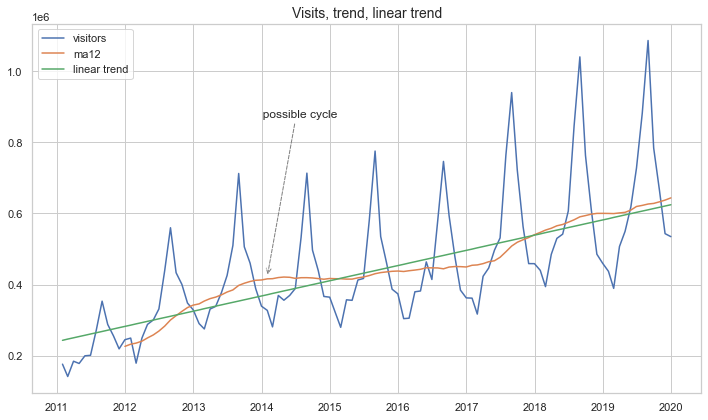

In [35]:
# plotting lr results
fig = plt.figure(figsize=(10, 6))

plt.plot(ts[["Visitors", "MA12", "LR"]])
plt.legend(["visitors", "ma12", "linear trend"])
plt.title("Visits, trend, linear trend", size=14)
plt.annotate("  possible cycle",
             xy=(pd.Timestamp('2014-01-31'), 423000),
             xytext=(pd.Timestamp('2013-11-30'), 870000),
             arrowprops=dict(arrowstyle='->', ls="dashed", lw=1, color="gray"))

plt.tight_layout()
plt.show()

## Time series forecasting

### Forecast based on linear trend

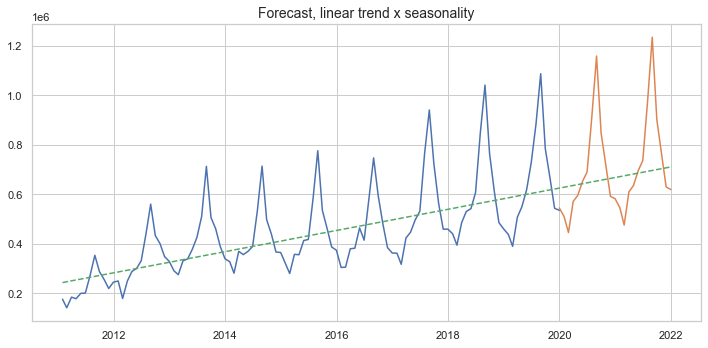

In [36]:
trend = [x * slope + intercept for x in range(132)]
season = seasonality*11
y_pred = [a*b for a, b in zip(trend, season)]
labels = pd.date_range(start="2011-01-31", end="2021-12-31", freq="M")

ts_fcast = pd.DataFrame({"Trend": trend, "Forecast": y_pred,
                         "Index": labels}).set_index("Index", drop=True)
ts_fcast["Visitors"] = ts["Visitors"]

fig = plt.figure(figsize=(10, 5))

plt.plot(ts_fcast["Visitors"])
plt.plot(ts_fcast["Forecast"][107:])
plt.plot(ts_fcast["Trend"], linestyle="dashed")
plt.title("Forecast, linear trend x seasonality", size=14)

plt.tight_layout()
plt.show()

### R2 metric

The metric value is very high. The model explaines 99.2% of the time series variance.

In [37]:
# calculating R2
vs_mean = ts_fcast["Visitors"].mean()
SSE = sum((ts_fcast["Visitors"][:108] - ts_fcast["Forecast"][:108])**2)
SSW = sum((ts_fcast["Visitors"][:108] - ts_fcast["Visitors"]
           [:108].transform(func=lambda x:  x - vs_mean))**2)
R2 = 1-SSE/SSW
print("R2:", round(R2, 3))

R2: 0.992


The formula I am using to clculate R-squared is:

$$ R^2 = \frac{SSE}{SST} $$

Where:
- SSE = sum of squared error
- SST = sum of squared total 

More precisely:

$$ R^2 = \frac{\sum (y- \hat y)^2}{\sum (y-\bar y)^2} $$

Where:
- $y$ = actual value
- $\hat y$ = predicted value of $y$
- $\bar y$ = mean of $y$ values

### Forecast based on ARIMA model

Trend Elements of the ARIMA model
- p: Trend autoregression order. Periods taken for autoregressive model.
- d: Trend difference order. Integrated order difference.
- q: Trend moving average order. Number of periods in moving average model.

#### Testing different orders for stationarity

In [38]:
# adfuller tests for stationarity
print("TS d=0 P-value: ", adfuller(ts["Visitors"])[1].round(3))
print("TS d=1 P-value: ",
      adfuller(ts["Visitors"].diff(periods=1).dropna())[1].round(3))
print("TS d=2 P-value: ",
      adfuller(ts["Visitors"].diff(periods=1).diff(periods=1).dropna())[1].round(3))
print("The integrated order d=n with the p-value less than 0.05 is the right one.")

TS d=0 P-value:  0.776
TS d=1 P-value:  0.142
TS d=2 P-value:  0.0
The integrated order d=n with the p-value less than 0.05 is the right one.


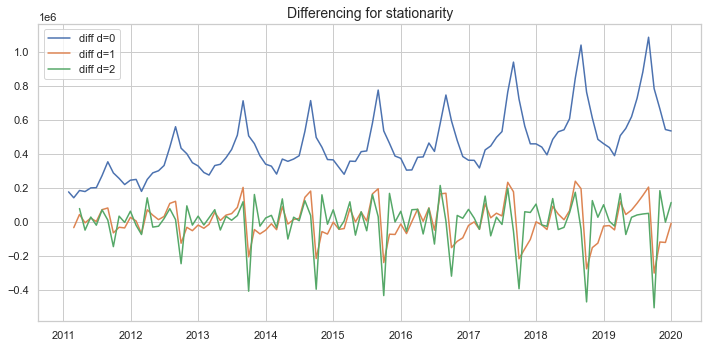

In [39]:
# Plotting the results
fig = plt.figure(figsize=(10, 5))

plt.plot(ts["Visitors"])
plt.plot(ts["Visitors"].diff(periods=1))
plt.plot(ts["Visitors"].diff(periods=1).diff(periods=1))
plt.legend(["diff d=0", "diff d=1", "diff d=2"])
plt.title("Differencing for stationarity", size=14)

fig.tight_layout()
plt.show()

#### Auto Corelation, Partial Autocorrelation

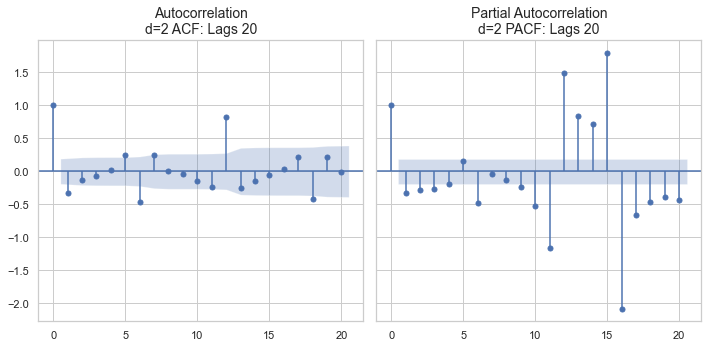

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
plot_acf(ts["Visitors"].diff(periods=1).diff(
    periods=1).dropna(), lags=20, ax=ax[0])  # q
ax[0].set_title("Autocorrelation\nd=2 ACF: Lags 20", size=14)
plot_pacf(ts["Visitors"].diff(periods=1).diff(
    periods=1).dropna(), lags=20, ax=ax[1])  # p
ax[1].set_title("Partial Autocorrelation\nd=2 PACF: Lags 20", size=14)

fig.tight_layout()
plt.show()

#### Choosing p, d, q elements of the model

In [41]:
%time

p = d = q = range(0, 7)
pdq = list(itertools.product(p, d, q))

params = []
aic = []

for param in pdq:
    try:
        model = ARIMA(ts["Visitors"], order=param, freq="M")
        arima_fit = model.fit()
        params.append(param)
        aic.append(arima_fit.aic)
    except:
        continue

order = params[aic.index(min(aic))]
p = order

Wall time: 0 ns


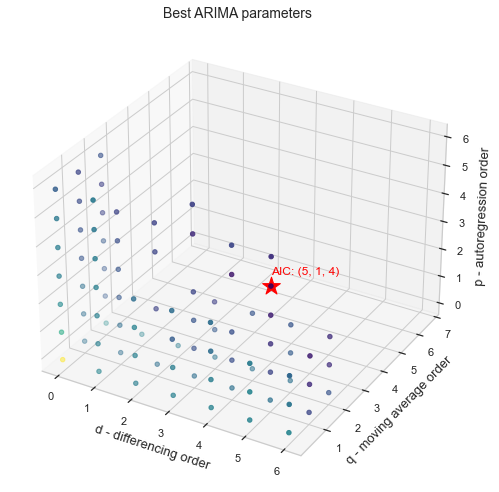

In [42]:
p = [p for p, d, q in params]
d = [d for p, d, q in params]
q = [q for p, d, q in params]

fig = plt.figure(figsize=(9, 7))

ax = plt.axes(projection='3d')
ax.scatter(p, d, q, c=aic, cmap="viridis")
ax.scatter(*order, c="red", s=350, marker="*")

a, b, c = order
c = c* 1.1
ax.text(a,b,c, f"AIC: {order}", c="red")


ax.set_title("Best ARIMA parameters", size=14)
ax.set_xlabel("d - differencing order", size=13)
ax.set_ylabel("q - moving average order", size=13)
ax.set_zlabel("p - autoregression order", size=13)
ax.set_yticks([1,2,3,4,5,6,7])

plt.tight_layout()
plt.show()

#### ARIMA model

In [43]:
X = ts["Visitors"].values
model = ARIMA(X, order=order)
arima_fit = model.fit()
print(arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  107
Model:                 ARIMA(5, 1, 4)   Log Likelihood               -1340.021
Method:                       css-mle   S.D. of innovations          61264.394
Date:                Mon, 22 Nov 2021   AIC                           2702.042
Time:                        19:49:05   BIC                           2731.443
Sample:                             1   HQIC                          2713.961
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3353.1820   2169.321      1.546      0.122    -898.609    7604.973
ar.L1.D.y      1.3448      0.096     14.024      0.000       1.157       1.533
ar.L2.D.y     -1.3541      0.165     -8.182      0.0

#### ARIMA forecast visualisation

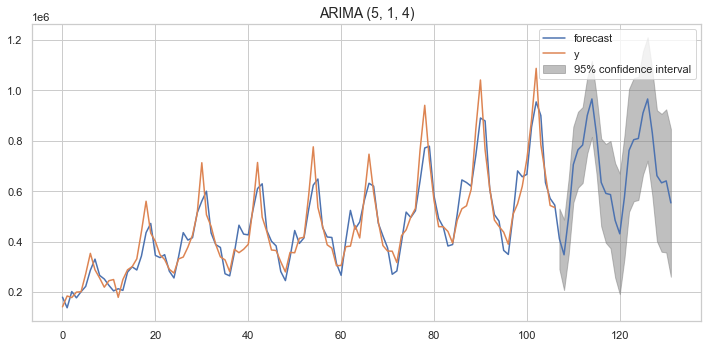

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))

arima_fit.plot_predict(1, 132, ax=ax)
ax.set_title("ARIMA {}".format(order), size=14)

fig.tight_layout()
plt.show()